In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import numpy as np
import matplotlib.pyplot as plt
import sklearn.utils
import tensorflow as tf
import h5py
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

%matplotlib inline

In [2]:
IMG_WIDTH = 32 # Side for each transformed Image
IMG_HEIGHT = 32
IMG_DEPTH = 1 # RGB files

In [3]:
MAX_DIGITS = 5

In [4]:
imgsAll = np.empty(shape = (0,IMG_HEIGHT, IMG_WIDTH), dtype=float)
labelsAll = np.empty(shape = (0,MAX_DIGITS), dtype=float)
numDigitsAll = np.empty(shape = (0), dtype=float)

In [5]:
for numDigits in range(1,MAX_DIGITS + 1):
    h5FileName = 'svhn_' + str(numDigits) + '.h5'
    data = h5py.File(h5FileName)
    imgs = np.array(data['images']).astype(float)
    labels = np.array(data['digits'])
    # Buff up labels to MAX_DIGITS width ( use 10 for undefined value)
    valsToFill = np.full(shape = (labels.shape[0], MAX_DIGITS - numDigits ), fill_value= 10.0, dtype = float)
    labels = np.concatenate ((labels, valsToFill), axis = 1)
    # Concat to full Dataset
    imgsAll = np.concatenate((imgsAll, imgs), axis = 0)
    labelsAll = np.concatenate((labelsAll, labels), axis = 0)
    numDigitsAll = np.concatenate((numDigitsAll, np.full(labels.shape[0], numDigits, dtype= float))) # Add num of digits for this set of images

In [6]:
print (imgsAll.shape)
print (labelsAll.shape)
print (numDigitsAll.shape)

(202353, 32, 32)
(202353, 5)
(202353,)


[  4.   6.   8.  10.  10.]
3.0


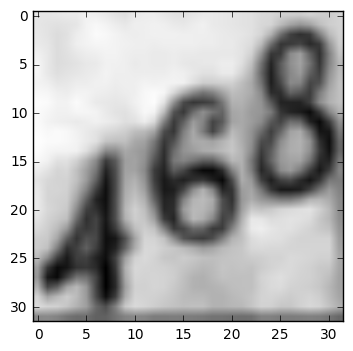

In [7]:
print (labelsAll[100000])
plt.imshow(imgsAll[100000], cmap='gray')
print (numDigitsAll[100000])

In [8]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    index_update = [int(x) for x in index_offset + labels_dense]
    labels_one_hot.flat[index_update] = 1
    return labels_one_hot

In [9]:
# Get the dataset
X = imgsAll.reshape([-1, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH])
Y = labelsAll

In [10]:
#X, Y = sklearn.utils.shuffle(X, Y, random_state=0)

In [11]:
# Generate validation set
ratio = 0.9 # Train/Test set
randIdx = np.random.random(imgsAll.shape[0]) <= ratio
#print (sum(map(lambda x: int(x), randIdx)))
X_train = X[randIdx]
Y_train = Y[randIdx]
X_test = X[randIdx == False]
Y_test = Y[randIdx == False]
Y_train = [dense_to_one_hot(Y_train[:,idx], num_classes= 11) for idx in range(Y_train.shape[1])] 
Y_test = [dense_to_one_hot(Y_test[:,idx], num_classes= 11) for idx in range(Y_test.shape[1])] 
#del X, Y # release some space

In [12]:
print (X_train.shape)
print (Y_train[0].shape)

(181990, 32, 32, 1)
(181990, 11)


In [13]:
# Building convolutional network

# Building convolutional network
for numLayers in [1,2,3,4,5]: # Num of Conv layer sets to use
    with tf.Graph().as_default():
        
        # Real-time data preprocessing
        img_prep = ImagePreprocessing()
        img_prep.add_featurewise_zero_center()
        img_prep.add_featurewise_stdnorm()

        # Real-time data augmentation
        img_aug = ImageAugmentation()
        #img_aug.add_random_flip_leftright()
        img_aug.add_random_rotation(max_angle=25.)
        input = input_data(shape=[None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH], name='input',
                                                                    data_preprocessing=img_prep,
                                                                    data_augmentation=img_aug)

        # Building convolutional network
        x = tflearn.conv_2d(input, 32, 3, activation='relu', name='conv1_1')
        x = tflearn.conv_2d(x, 32, 3, activation='relu', name='conv1_2')
        x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool1')
        #x = local_response_normalization(x)

        if numLayers >= 2:
            x = tflearn.conv_2d(x, 64, 3, activation='relu', name='conv2_1')
            x = tflearn.conv_2d(x, 64, 3, activation='relu', name='conv2_2')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool2')
            #x = local_response_normalization(x)
    
        if numLayers >= 3:
            x = tflearn.conv_2d(x, 256, 3, activation='relu', name='conv3_1')
            x = tflearn.conv_2d(x, 256, 3, activation='relu', name='conv3_2')
            x = tflearn.conv_2d(x, 256, 3, activation='relu', name='conv3_3')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool3')

        if numLayers >= 4:
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv4_1')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv4_2')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv4_3')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool4')

        if numLayers >= 5:
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv5_1')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv5_2')
            x = tflearn.conv_2d(x, 512, 3, activation='relu', name='conv5_3')
            x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool5')

        # Training heads
        allHeads = []
        for idx in range(MAX_DIGITS):
            fc = fully_connected(x, 1024, activation='tanh')
            #fc = dropout(fc, 0.8)
            #fc = fully_connected(fc, 1024, activation='tanh')
            #fc = dropout(fc, 0.8)
            softmax = fully_connected(fc, 11, activation='softmax')
            networkOut = regression(softmax, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy', name='target' + str(idx))
            allHeads.append(networkOut)

        network = tflearn.merge(allHeads, mode='elemwise_sum')

        model = tflearn.DNN(network, tensorboard_verbose=5)
        feedTrainDict = {'target'+ str(i): Y_train[i] for i in range(MAX_DIGITS)}
        #feedTrainDict = {'target0': Y_train[0]}
        feedTestList =  [Y_test[i] for i in range(MAX_DIGITS)]
        #feedTestList =  Y_test[0]
        model.fit({'input': X_train}, feedTrainDict, shuffle = True,
                  validation_set= (X_test, feedTestList), n_epoch=3, show_metric=True, snapshot_step=1000,
                  run_id='EndToEnd/convnet_svhn_' + str(numLayers))

Training Step: 8532  | total loss: 9.08266
| Adam_0 | epoch: 003 | loss: 2.08768 - acc: 0.2440 | val_loss: 2.08175 - val_acc: 0.2804 -- iter: 181990/181990
| Adam_1 | epoch: 003 | loss: 2.44668 - acc: 0.1070 | val_loss: 2.42813 - val_acc: 0.1059 -- iter: 181990/181990
| Adam_0 | epoch: 003 | loss: 2.10177 - acc: 0.4112 | val_loss: 2.10983 - val_acc: 0.4009 -- iter: 181990/181990
| Adam_1 | epoch: 003 | loss: 2.44640 - acc: 0.9286 | val_loss: 0.46128 - val_acc: 0.9274 -- iter: 181990/181990
| Adam | epoch: 003 | loss: 0.00013 - acc: 1.0000 | val_loss: 0.00966 - val_acc: 0.9995 -- iter: 181990/181990
Training Step: 8532  | total loss: 9.08266
| Adam_0 | epoch: 003 | loss: 2.08768 - acc: 0.2440 | val_loss: 2.08175 - val_acc: 0.2804 -- iter: 181990/181990
| Adam_1 | epoch: 003 | loss: 2.44668 - acc: 0.1070 | val_loss: 2.42813 - val_acc: 0.1059 -- iter: 181990/181990
| Adam_0 | epoch: 003 | loss: 2.10177 - acc: 0.4112 | val_loss: 2.10983 - val_acc: 0.4009 -- iter: 181990/181990
| Adam_1 | e